# Log-ARIMA 모델을 이용하여 내일의 KOSPI 주가 예측하기

In [1]:
# 라이브러리 설치
!pip install statsmodels

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller # d값 때 정상성 여부 확인에 사용.
from statsmodels.tsa.stattools import acf # q값을 찾기 위해 사용.
from sklearn.metrics import mean_squared_error # 두 모델의 손실을 정량적으로 평가하기 위해 사용.

## 1. 데이터 로드 및 전처리

In [2]:
# 데이터 로드 및 분할(로그 변환 포함)
url = "https://raw.githubusercontent.com/2025-Matrix/stock-market-prediction/refs/heads/main/data/kospi_data_final.csv"

df = pd.read_csv(url, index_col='Date', parse_dates=True) # Date 같은 날짜 문자열을
# 문자열 -> datetime 객체로 자동 변환하겠다는 것.

kospi_series = df['KOSPI_Close'] # 값 + 인덱스만 가진 pandas의 1차원 데이터 구조.
# 데이터프레임의 한 열이라고 생각하면 됨.

In [3]:
# 훈련 데이터와 테스트 데이터 8대2 분리
split_point = int(len(kospi_series) * 0.8)
train_data = kospi_series[:split_point]
test_data = kospi_series[split_point:]

print(f"훈련 데이터 : {len(train_data)}개, 테스트 데이터 : {len(test_data)}개")

훈련 데이터 : 4348개, 테스트 데이터 : 1087개


## Log-ARIMA
- 로그 ARIMA는 로그 성질로 인해 로그+차분 후 값은 변화율처럼 해석 가능함.
- 로그 변환: 분산 안정화 효과 있음, 로그 변환하면 정상성에 더 가까워짐.
- 데이터가 모두 양수이고, 값이 커질수록 변동도 커지는 형태이므로 보통 분산이 평균의 함수(특히 비례) 형태를 보임.
- 로그를 취하면 그 프로포션이 줄어들고, 변화 폭이 일정해져서 분산이 상대적으로 안정되는 경향이 생김.
- 참고로, 분산 안정화는 정상성이 아님.
- 정상성이 더 큰 개념. 평균, 분산, 공분산까지 모두 일정해야 함.

In [4]:
# 정답지(원래 스케일) 보존-나중에 RMSE 계산할 때.
test_data_actual = test_data

train_data_log = np.log(train_data)
test_data_log = np.log(test_data)

## 2. ARIMA 모델의 최적 파라미터 d, q 값 찾기

In [5]:
# d값 찾기(ADF 검정)
# 원본(로그) 데이터 검정
result_log_orig = adfuller(train_data_log)
print(f'Log 원본 p-value : {result_log_orig[1]}') # p > 0.05

Log 원본 p-value : 0.2606133540970954


In [6]:
# 1차 차분 데이터 검정
diff_log_1 = train_data_log.diff(1).dropna()
result_log_diff1 = adfuller(diff_log_1)
print(f'Log 1차 차분 p-value : {result_log_diff1[1]}') # p < 0.05

# p-value가 0.05 미만이면 정상성 확보. d=1로 결정.
if result_log_diff1[1] < 0.05:
    d = 1

Log 1차 차분 p-value : 1.985269240253758e-23


In [7]:
# q값 찾기(ACF)
acf_values, confint = acf(diff_log_1, alpha=0.05)  # 95% 신뢰구간
# 신뢰구간과 비교해서 밴드 밖에 나오는 값 세기
# confint[1:, 1] -> lag 1부터의 상한 신뢰구간
# confint[1:, 0] -> lag 1부터의 하한 신뢰구간
q_auto = sum((acf_values[1:] > confint[1:,1]) | (acf_values[1:] < confint[1:,0]))

print("컴퓨터가 수치로 찾은 q값 : ", q_auto)
q2 = q_auto

컴퓨터가 수치로 찾은 q값 :  0


In [8]:
# LSTM과 비교하기 위해 5일치로 설정.

p2 = 5

p=5로 설정한 이유:
- LSTM과의 비교를 위해 5일치 정보를 입력으로 사용한다는 조건을 맞추기 위한 실용적 선택이지, 통계적으로 가장 적절한 AR 차수를 찾은 결과는 아님.
- 사실 ARIMA에서 p는 ACF, PACF 분석이나 AIC 기준 등을 통해 결정하는 것이 원칙
- 임의로 5로 설정하는 것은 과적합의 위험이나 불필요한 복잡도를 초래할 수 있어 이론적으로는 문제가 있는 방식임.
- 그럼에도 p=5를 쓰는 이유는, 이번 실험의 목적이 모델 간 입력 정보의 크기를 동일하게 맞춰서 비교 가능성을 확보하는 것에 있기 때문에, 통계적으로 최적이진 않더라도 조건 통일을 위해 고정한 것.

## 3. ARIMA 모델 학습 및 예측

In [9]:
# 모델 생성 및 훈련
model2 = ARIMA(train_data_log, order=(p2, d, q2))
model_fit2 = model2.fit()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


- LSTM과의 비교를 위한 하루 단위 예측.
- 훈련된 모델에 새로운 시계열을 이어붙여 상태만 맞춰주기.
- 만약 apply() 안 하면 train 끝에서 예측이 단절돼서 test 데이터의 실제 값이 모델에 전달되지 않음.
- ARIMA는 test의 t-1 값을 모르게 되므로 one-step 예측 불가능
- LSTM처럼 매일 업데이트되는 방식으로 비교 불가라는 것.

In [ ]:

full_data_log = np.log(kospi_series)
model_with_test_data = model_fit2.apply(full_data_log)

# 테스트 기간만 선택하여 예측 수행
# dynamic=False : 모델이 테스트 기간 예측 시 실제 이전 값을 사용하여 예측
# (one-step ahead forecast)
# LSTM과 같은 방식으로 매일 데이터를 받아 예측
log_predictions = model_with_test_data.predict(
    start=test_data.index[0], end=test_data.index[-1], dynamic=False)

# 로그 스케일을 다시 지수 변환하여 원상복구
predictions2 = np.exp(log_predictions)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


## 4. 성능 평가 및 시각화

In [11]:
# 실제 테스트 데이터와 예측 데이터의 인덱스를 맞춰, 날짜 불일치 방지
# common_index Pandas Index 객체 : test 실제 값과 예측 값의 날짜가 정확히 같은 날들만 골라서 매칭
common_index = test_data_actual.index.intersection(predictions2.index)
final_actual = test_data_actual.loc[common_index]
final_pred = predictions2.loc[common_index]

# 성능 평가
rmse2 = np.sqrt(mean_squared_error(final_actual, final_pred))
print(f"Log-ARIMA 최종 결과 RMSE : {rmse2}")

Log-ARIMA 최종 결과 RMSE : 29.79083293626862


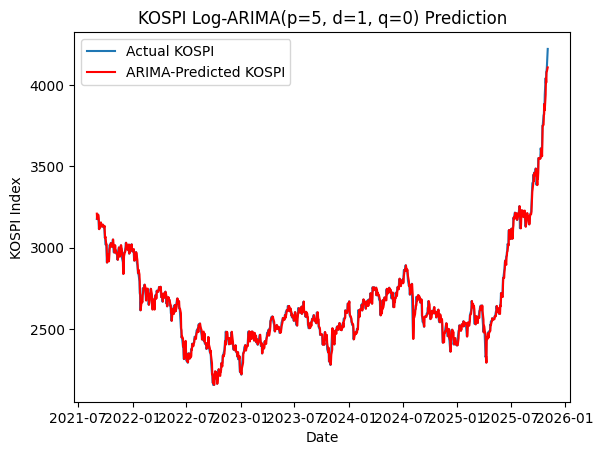

In [12]:
# 그래프 그리기
plt.plot(test_data, label="Actual KOSPI")
plt.plot(final_pred, label="ARIMA-Predicted KOSPI", color='red')
plt.title(f'KOSPI Log-ARIMA(p={p2}, d={d}, q={q2}) Prediction')
plt.xlabel('Date')
plt.ylabel('KOSPI Index')
plt.legend()

# 그래프 이미지 저장 및 출력
plt.savefig('arima_prediction_result.png', dpi=300)
plt.show()
